# Intro
Basically this environment is to essay different things from preprocessing to everything else. 

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from tensorflow.keras import layers

def set_seed(seed=35643419):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(35643419)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
#train.head()

In [4]:
#We have more or less the same distribution of numbers
#sns.histplot(train.label)

In [5]:
labels = train['label']
pixels = train.drop('label', axis=1)

images = pixels.values.reshape(-1, 28, 28)

#for i in [0,1,2,3,4]:
 #   plt.imshow(images[i], cmap='gray')
  #  plt.title(f"Label: {labels[i]}")
   # plt.show()

In [6]:
pixels_train, pixels_valid, labels_train, labels_valid = train_test_split(
    pixels,  
    labels,  
    test_size=0.3,
    random_state=35643419 
)

In [7]:
images_train = pixels_train.values.reshape(-1, 28, 28)
images_valid = pixels_valid.values.reshape(-1,28,28)

In [8]:
labels_train_one_hot = tf.keras.utils.to_categorical(labels_train, num_classes=10)
labels_valid_one_hot = tf.keras.utils.to_categorical(labels_valid, num_classes=10)

In [9]:
images_train_with_channel = images_train[..., np.newaxis]
images_valid_with_channel = images_valid[..., np.newaxis]

In [10]:
#pretrained_base = tf.keras.models.load_model(
 #   '../input/cv-course-models/cv-course-models/inceptionv3',
#)
#pretrained_base.trainable = False

In [11]:
model = keras.Sequential([
    preprocessing.Rescaling(scale=1./255),
    #Filter + detect : obtain 32 features, moving 1 pixel in the two dimensions, treating borders equally (same)
    layers.Conv2D(filters=32,kernel_size=3,strides=1,padding='valid',activation='relu', input_shape=(28, 28, 1)),
    #Condense features
    layers.MaxPool2D(pool_size=2,strides=3,padding='valid'),

    layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='valid',activation='relu'),
    layers.MaxPool2D(pool_size=2,strides=1,padding='valid'),
    
    layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu'),
    layers.MaxPool2D(pool_size=2, strides=1, padding='valid'),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax'),
])

In [12]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [13]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

In [14]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model.h5',  # Save the best weights to this file
    save_best_only=True,  # Only save the best weights based on the validation loss
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Mode can be 'min' or 'max' depending on the metric to minimize or maximize
    verbose=1  # Display messages when saving the best weights
)

In [15]:
history = model.fit(
    images_train_with_channel, 
    labels_train_one_hot,
    validation_data=(images_valid_with_channel, labels_valid_one_hot),
    epochs=20,
    callbacks=[early_stopping,model_checkpoint],
)

Epoch 1/20
910/919 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.9036
Epoch 1: val_loss improved from inf to 0.08081, saving model to best_model.h5
919/919 [==============================] - 13s 5ms/step - loss: 0.3101 - accuracy: 0.9042 - val_loss: 0.0808 - val_accuracy: 0.9732
Epoch 2/20
907/919 [============================>.] - ETA: 0s - loss: 0.0837 - accuracy: 0.9751
Epoch 2: val_loss improved from 0.08081 to 0.04132, saving model to best_model.h5
919/919 [==============================] - 4s 4ms/step - loss: 0.0836 - accuracy: 0.9751 - val_loss: 0.0413 - val_accuracy: 0.9863
Epoch 3/20
910/919 [============================>.] - ETA: 0s - loss: 0.0561 - accuracy: 0.9842
Epoch 3: val_loss did not improve from 0.04132
919/919 [==============================] - 4s 4ms/step - loss: 0.0562 - accuracy: 0.9841 - val_loss: 0.0777 - val_accuracy: 0.9791
Epoch 4/20
907/919 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9878
Epoch 4: val_lo

In [16]:
history_frame = pd.DataFrame(history.history)

<Axes: >

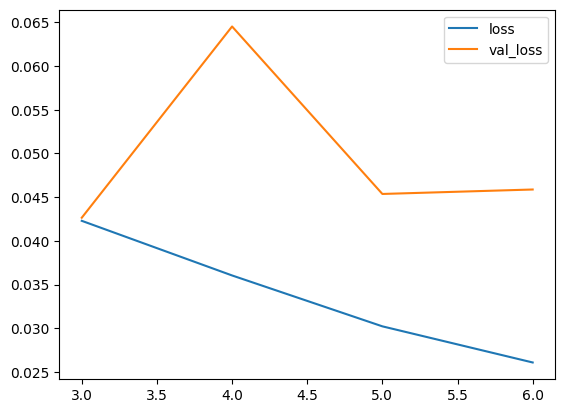

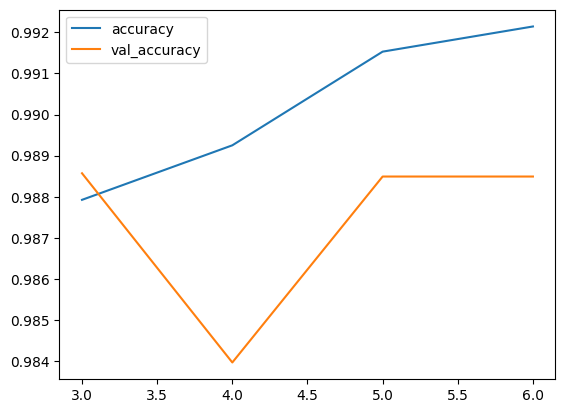

In [17]:
history_frame.loc[3:, ['loss', 'val_loss']].plot()
history_frame.loc[3:, ['accuracy', 'val_accuracy']].plot()

In [18]:
best_model = keras.models.load_model('best_model.h5')

In [19]:
valid_loss, valid_acc = best_model.evaluate(images_valid_with_channel, labels_valid_one_hot)
print('valid_acc:', valid_acc)

394/394 [==============================] - 1s 2ms/step - loss: 0.0413 - accuracy: 0.9863
valid_acc: 0.9863492250442505


In [20]:
images_test = test.values.reshape(-1, 28, 28)
images_test_with_channel = images_test[..., np.newaxis]

In [21]:
pred = best_model.predict(images_test)

875/875 [==============================] - 2s 2ms/step


In [22]:
predicted_classes = np.argmax(pred, axis=1)

In [23]:
image_ids = np.arange(1, len(predicted_classes) + 1)

In [24]:
df_submission = pd.DataFrame({
    'ImageId': image_ids,
    'Label': predicted_classes
})

In [25]:
df_submission.to_csv('submission8.csv', index=False)